# 第7章 ニューラルネットワーク・ディープラーニング

# 7.1 ニューロンモデル

### 7.1.1 神経細胞

### 7.1.2 ニューロンモデル

## 7.2 ニューラルネットワークモデル

### 7.2.1 2層フィードフォワードニューラルネット

### 7.2.2 2層フィードフォワードニューラルネットの実装

In [2]:
# -- リスト 7-1-(1)
import numpy as np

# データ生成 ----------
np.random.seed(seed=1)                # 乱数を固定
N = 200                               # データの数
K = 3                                 # 分布の数
T = np.zeros((N, 3), dtype=np.uint8)  # 空のTを準備
X = np.zeros((N, 2))                  # 空のXを準備
X0_min, X0_max = -3, 3                # X0の範囲、表示用
X1_min, X1_max = -3, 3                # X1の範囲、表示用
prm_mu = np.array([[-0.5, -0.5], [0.5, 1.0], [1, -0.5]])   # 分布の中心
prm_sig = np.array([[0.7, 0.7], [0.8, 0.3], [0.3, 0.8]])   # 分布の分散
prm_pi = np.array([0.4, 0.8, 1])       # 各分布への割合を決めるパラメータ
for n in range(N):
    r = np.random.rand()
    # 3クラス用の目標データTを作成
    for k in range(K):
        if r < prm_pi[k]:
            T[n, k] = 1
            break
    # Tに対して入力データXを作成
    for k in range(2):
        X[n, k] =  \
            np.random.randn() * prm_sig[T[n, :] == 1, k] \
            + prm_mu[T[n, :] == 1, k]   

In [3]:
# リスト 7-1-(2)
# 訓練データとテストデータに分割 ----------
TrainingRatio = 0.5
N_training = int(N * TrainingRatio)
X_train = X[:N_training, :]
X_test = X[N_training:, :]
T_train = T[:N_training, :]
T_test = T[N_training:, :]

# データの保存 ----------
np.savez(
    "ch7_data.npz",
    X_train=X_train, T_train=T_train, X_test=X_test, T_test=T_test,
    X0_min=X0_min, X0_max=X0_max, X1_min=X1_min, X1_max=X1_max,
)

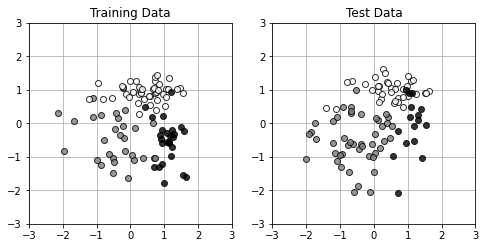

In [4]:
# リスト 7-1-(3)
%matplotlib inline
import matplotlib.pyplot as plt

# データ表示 ----------
def show_data(x, t):
    K = t.shape[1]  # tの列数からクラス数を取得
    col = ["gray", "white", "black"]
    for k in range(K):
        plt.plot(
            x[t[:, k] == 1, 0], x[t[:, k] == 1, 1], col[k],
            marker="o", linestyle="None",
            markeredgecolor="black", alpha=0.8,
        )
    plt.xlim(X0_min, X0_max)
    plt.ylim(X1_min, X1_max)

# メイン ----------
plt.figure(figsize=(8, 3.7))
# 訓練データ表示
plt.subplot(1, 2, 1)
show_data(X_train, T_train)
plt.title("Training Data")
plt.grid()
# テストデータ表示
plt.subplot(1, 2, 2)
show_data(X_test, T_test)
plt.title("Test Data")
plt.grid()
plt.show()

In [5]:
# リスト 7-1-(4)
# シグモイド関数 ----------
def sigmoid(a):
    y = 1 / (1 + np.exp(-a))  # 式7-6
    return y

# ネットワーク  ----------
def FNN(wv, M, K, x):
    N, D = x.shape  # 入力次元
    w = wv[: M * (D + 1)]     # 中間層ニューロンへの重み
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1) :]     # 出力層ニューロンへの重み
    v = v.reshape((K, M + 1))
    b = np.zeros((N, M + 1))  # 中間層ニューロンの入力総和
    z = np.zeros((N, M + 1))  # 中間層ニューロンの出力
    a = np.zeros((N, K))      # 出力層ニューロンの入力総和
    y = np.zeros((N, K))      # 出力層ニューロンの出力
    for n in range(N):
        # 式7-14、式7-15で中間層の出力zを計算
        for m in range(M):
            # (A) x[n, :]の末尾に1を加える
            x_add1 = np.r_[x[n, :], 1]
            b[n, m] = w[m, :] @ x_add1
            z[n, m] = sigmoid(b[n, m])
        # 式7-16、式7-17で出力層の出力yを計算
        z[n, M] = 1  # ダミーニューロン
        u = 0
        for k in range(K):
            a[n, k] = v[k, :] @ z[n, :]
            u = u + np.exp(a[n, k])
        for k in range(K):
            y[n, k] = np.exp(a[n, k]) / u
    return y, a, z, b

# テスト ----------
wv = np.ones(15)
M, K = 2, 3
y, a, z, b = FNN(wv, M, K, X_train[:2, :])
print("y =\n", np.round(y, 6))
print("a =\n", np.round(a, 6))
print("z =\n", np.round(z, 6))
print("b =\n", np.round(b, 6))

y =
 [[0.333333 0.333333 0.333333]
 [0.333333 0.333333 0.333333]]
a =
 [[2.697184 2.697184 2.697184]
 [1.491726 1.491726 1.491726]]
z =
 [[0.848592 0.848592 1.      ]
 [0.245863 0.245863 1.      ]]
b =
 [[ 1.723598  1.723598  0.      ]
 [-1.120798 -1.120798  0.      ]]


### 7.2.3 数値微分法

In [6]:
# リスト 7-1-(5)
# 平均交差エントロピー誤差 ----------
def cee_FNN(wv, M, K, x, t):
    N, D = x.shape
    y, a, z, b = FNN(wv, M, K, x)
    # (A) 式7-18の計算
    cee = -(t.reshape(-1) @ np.log(y.reshape(-1))) / N
    return cee

# テスト ----------
wv = np.ones(15)
M, K = 2, 3
cee = cee_FNN(wv, M, K, X_train[:2, :], T_train[:2, :])
print(f"cee = {cee:.6}")

cee = 1.09861


numerical dwv
dwv =
 [ 0.088481  0.19158  -0.051398  0.012815 -0.14468  -0.142428 -0.02992
  0.013513 -0.111156 -0.101044 -0.09428  -0.468556  0.130964  0.080766
  0.579713]


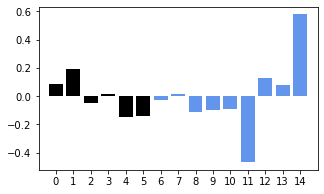

In [7]:
# リスト 7-1-(6)
# 平均交差エントロピー誤差の数値微分 ----------
def dcee_FNN_num(wv, M, K, x, t):
    epsilon = 0.001
    dwv = np.zeros_like(wv)
    # 式7-20の計算
    for iwv in range(len(wv)):
        wv_shifted = wv.copy()
        wv_shifted[iwv] = wv[iwv] + epsilon
        mse1 = cee_FNN(wv_shifted, M, K, x, t)
        wv_shifted[iwv] = wv[iwv] - epsilon
        mse2 = cee_FNN(wv_shifted, M, K, x, t)
        dwv[iwv] = (mse1 - mse2) / (2 * epsilon)
    return dwv

# -- dwvの棒グラフによる表示 ----------
def show_dwv(dwv, D, M):
    v_start = M * (D + 1)     # v の始めのインデックス
    v_end = dwv.shape[0] - 1  # v の最後のインデックス
    plt.bar(  # dwの表示
        range(0, v_start), dwv[:v_start],
        color="black", align="center",
    )
    plt.bar(  # dvの表示
        range(v_start, v_end + 1), dwv[v_start:],
        color="cornflowerblue", align="center",
    )
    plt.xticks(range(0, v_end + 1))
    plt.xlim(-1, v_end + 1)

# テスト ----------
D, M, K, N = 2, 2, 3, 2
wv_n = M * (D + 1) + K * (M + 1)
np.random.seed(seed=1)
wv = np.random.normal(
    0.0, 1.0, wv_n)  # 平均0.0分散1.0のwv_n個の乱数
dwv = dcee_FNN_num(
    wv, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dwv")
print("dwv =\n", np.round(dwv, 6))

# グラフ描画 ----------
plt.figure(figsize=(5, 3))
show_dwv(dwv, D, M)
plt.show()

### 7.2.4 数値微分法による勾配法

In [7]:
# リスト 7-1-(7)
import time

# 数値微分を使った勾配法 -------
def fit_FNN_num(
    wv_init, M, K,
    x_train, t_train, x_test, t_test,
    tau_max, alpha,
):
    # 訓練データの誤差の履歴保存用
    cee_train = np.zeros(tau_max)
    # テストデータの誤差の履歴保存用
    cee_test = np.zeros(tau_max)
    # wv の履歴保存用
    wv = np.zeros((tau_max, len(wv_init)))
    # wv の初期値をセットし、そのときの誤差を計算
    wv[0, :] = wv_init
    cee_train[0] = cee_FNN(wv_init, M, K, x_train, t_train)
    cee_test[0] = cee_FNN(wv_init, M, K, x_test, t_test)
    # 勾配法
    for tau in range(tau_max - 1):  # (A)
        dcee = dcee_FNN_num(wv[tau, :], M, K, x_train, t_train)
        wv[tau + 1, :] = wv[tau, :] - alpha * dcee
        cee_train[tau + 1] = \
            cee_FNN(wv[tau + 1, :], M, K, x_train, t_train)
        cee_test[tau + 1] = \
            cee_FNN(wv[tau + 1, :], M, K, x_test, t_test)
    wv_final = wv[-1, :]
    return wv_final, wv, cee_train, cee_test

# メイン ----------
start_time = time.time()
D, M, K = 2, 2, 3
wv_n = M * (D + 1) + K * (M + 1)
np.random.seed(seed=1)
wv_init = np.random.normal(0, 0.01, wv_n)  # wvの初期値
tau_max = 1000  # (B) 学習ステップ
alpha = 0.5
# 勾配法でwvを計算
wv, wv_hist, cee_train, cee_test = \
    fit_FNN_num(
        wv_init, M, K,
        X_train, T_train, X_test, T_test,
        tau_max, alpha,
    )
# 計算時間の表示
calculation_time = time.time() - start_time
print(f"Calculation time:{calculation_time:.2f} sec")

Calculation time:132.19 sec


計算にかなり時間がかかります。結果を待ちましょう。



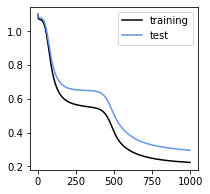

In [8]:
# リスト 7-1-(8)
# 学習誤差の表示 ----------
plt.figure(figsize=(3, 3))
plt.plot(cee_train, "black", label="training")
plt.plot(cee_test, "cornflowerblue", label="test")
plt.legend()
plt.show()

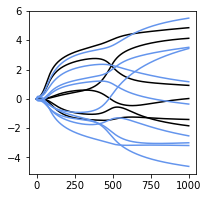

In [9]:
# リスト 7-1-(9)
# 重みの時間発展の表示 ----------
plt.figure(figsize=(3, 3))
v_start = M * (D + 1)  # v の始めのインデックス
plt.plot(wv_hist[:, :v_start], "black")
plt.plot(wv_hist[:, v_start:], "cornflowerblue")
plt.show()

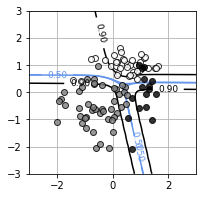

In [10]:
# リスト 7-1-(10)
# 境界線表示関数 ----------
def show_FNN(wv, M, K):
    x0_n, x1_n = 60, 60  # 等高線表示の解像度
    x0 = np.linspace(X0_min, X0_max, x0_n)
    x1 = np.linspace(X1_min, X1_max, x1_n)
    xx0, xx1 = np.meshgrid(x0, x1)
    # xx0とxx1を1次元ベクトルに展開し、
    # それぞれを0列目と1行目に配置した行列xを作る
    x = np.c_[xx0.reshape(-1), xx1.reshape(-1)]
    # 行列xに対するyを一度に求める
    y, a, z, b = FNN(wv, M, K, x)
    for ic in range(K):
        f = y[:, ic]
        f = f.reshape(x1_n, x0_n)
        cont = plt.contour(  # 等高線表示
            xx0, xx1, f,
            levels=[0.5, 0.9], colors=["cornflowerblue", "black"],
        )
        cont.clabel(fmt="%.2f", fontsize=9)
    plt.xlim(X0_min, X0_max)
    plt.ylim(X1_min, X1_max)

# 境界線の表示 ----------
plt.figure(figsize=(3, 3))
show_data(X_test, T_test)
show_FNN(wv, M, K)
plt.grid()
plt.show()

### 7.2.5 誤差逆伝搬法（バックプロパゲーション）

### 7.2.6 $\partial E / \partial v_{kj}$ を求める

### 7.2.7 $\partial E/\partial w_{ji}$ を求める

### 7.2.8 誤差逆伝搬法の実装

analytical dwv
dwv =
 [ 0.088481  0.19158  -0.051398  0.012815 -0.14468  -0.142428 -0.02992
  0.013513 -0.111156 -0.101044 -0.09428  -0.468556  0.130964  0.080766
  0.579713]
numerical dwv
dwv =
 [ 0.088481  0.19158  -0.051398  0.012815 -0.14468  -0.142428 -0.02992
  0.013513 -0.111156 -0.101044 -0.09428  -0.468556  0.130964  0.080766
  0.579713]


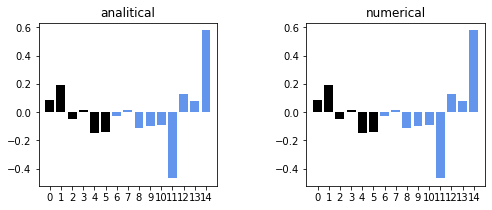

In [12]:
# リスト 7-1-(11)
# -- 解析的微分 ----------
def dcee_FNN(wv, M, K, x, t):
    N, D = x.shape
    # wv を w と v に戻す
    v_start = M * (D + 1)
    w = wv[:v_start]
    w = w.reshape(M, D + 1)
    v = wv[v_start:]
    v = v.reshape(K, M + 1)
    # ① 入力xを入れて出力yを得る
    y, a, z, b = FNN(wv, M, K, x)
    # 出力変数の準備
    dwv = np.zeros_like(wv)
    dw = np.zeros((M, D + 1))
    dv = np.zeros((K, M + 1))
    delta1 = np.zeros(M)  # 1 層目誤差
    delta2 = np.zeros(K)  # 2 層目誤差 (k=0 の部分は使わず)
    for n in range(N):  # (A)
        # ② 2層（出力層）の誤差を得る
        for k in range(K):
            delta2[k] = y[n, k] - t[n, k]
        # ③ 1層（中間層）の誤差を得る
        for j in range(M):
            delta1[j] = z[n, j] * (1 - z[n, j]) * v[:, j] @ delta2
        # ④ vの更新分（dv）を得る
        for k in range(K):
            dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
        # ④ wの更新分（dw）を得る
        for j in range(M):
            x_add1 = np.r_[x[n, :], 1]
            dw[j, :] = dw[j, :] + delta1[j] * x_add1 / N
    # dw と dv を合体させて dwv とする
    dwv = np.c_[
        dw.reshape((1, M * (D + 1))),
        dv.reshape((1, K * (M + 1))),
    ]
    dwv = dwv.reshape(-1)
    return dwv

# テスト ----------
D, M, K, N = 2, 2, 3, 2
wv_n = M * (D + 1) + K * (M + 1)
np.random.seed(seed=1)
wv = np.random.normal(0.0, 1.0, wv_n)
dwv_ana = dcee_FNN(wv, M, K, X_train[:N, :], T_train[:N, :])
dwv_num = dcee_FNN_num(wv, M, K, X_train[:N, :], T_train[:N, :])
# 結果表示
print("analytical dwv")
print("dwv =\n", np.round(dwv_ana, 6))
print("numerical dwv")
print("dwv =\n", np.round(dwv_num, 6))

# グラフ描画 ----------
plt.figure(figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)
# 解析的微分
plt.subplot(1, 2, 1)
show_dwv(dwv_ana, D, M)
plt.title("analitical")
# 数値微分
plt.subplot(1, 2, 2)
show_dwv(dwv_num, D, M)
plt.title("numerical")
plt.show()

In [13]:
# リスト 7-1-(12)
# 解析的微分を使った勾配法 -------
def fit_FNN(
    wv_init, M, K,
    x_train, t_train, x_test, t_test,
    tau_max, alpha,
):
    # 訓練データの誤差の履歴保存用
    cee_train = np.zeros(tau_max)
    # テストデータの誤差の履歴保存用
    cee_test = np.zeros(tau_max)
    # wv の履歴保存用
    wv = np.zeros((tau_max, len(wv_init)))
    # wv の初期値をセットし、そのときの誤差を計算
    wv[0, :] = wv_init
    cee_train[0] = cee_FNN(wv_init, M, K, x_train, t_train)
    cee_test[0] = cee_FNN(wv_init, M, K, x_test, t_test)
    # 勾配法
    for tau in range(tau_max - 1):
        dcee = dcee_FNN(wv[tau, :], M, K, x_train, t_train)  # (A)
        wv[tau + 1, :] = wv[tau, :] - alpha * dcee
        cee_train[tau + 1] = \
            cee_FNN(wv[tau + 1, :], M, K, x_train, t_train)
        cee_test[tau + 1] = \
            cee_FNN(wv[tau + 1, :], M, K, x_test, t_test)
    wv_final = wv[-1, :]
    return wv_final, wv, cee_train, cee_test

# メイン ----------
start_time = time.time()
D, M, K = 2, 2, 3
wv_n = M * (D + 1) + K * (M + 1)
np.random.seed(seed=1)
wv_init = np.random.normal(0, 0.01, wv_n)  # wvの初期値
tau_max = 1000  # (B) 学習ステップ
alpha = 0.5
# 勾配法でwvを計算
wv, wv_hist, cee_train, cee_test = \
    fit_FNN(
        wv_init, M, K,
        X_train, T_train, X_test, T_test,
        tau_max, alpha,
    )
# 計算時間の表示
calculation_time = time.time() - start_time
print(f"Calculation time:{calculation_time:.2f} sec")

Calculation time:17.23 sec


数値微分に比べて実行時間がかなり早くなっていますね。

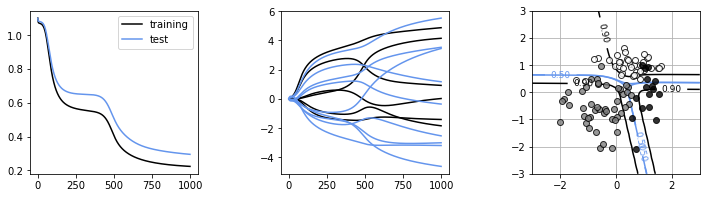

In [14]:
# リスト 7-1-(13)
D, M, K = 2, 2, 3
plt.figure(figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)

# 学習誤差の表示 ----------
plt.subplot(1, 3, 1)
plt.plot(cee_train, "black", label="training")
plt.plot(cee_test, "cornflowerblue", label="test")
plt.legend()

# 重みの時間発展の表示 ----------
plt.subplot(1, 3, 2)
v_start = M * (D + 1)  # v の始めのインデックス
plt.plot(wv_hist[:, :v_start], "black")
plt.plot(wv_hist[:, v_start:], "cornflowerblue")

# 境界線の表示 ----------
plt.subplot(1, 3, 3)
show_data(X_test, T_test)
show_FNN(wv, M, K)
plt.grid()
plt.show()

### 7.2.9 学習後のニューロンの特性

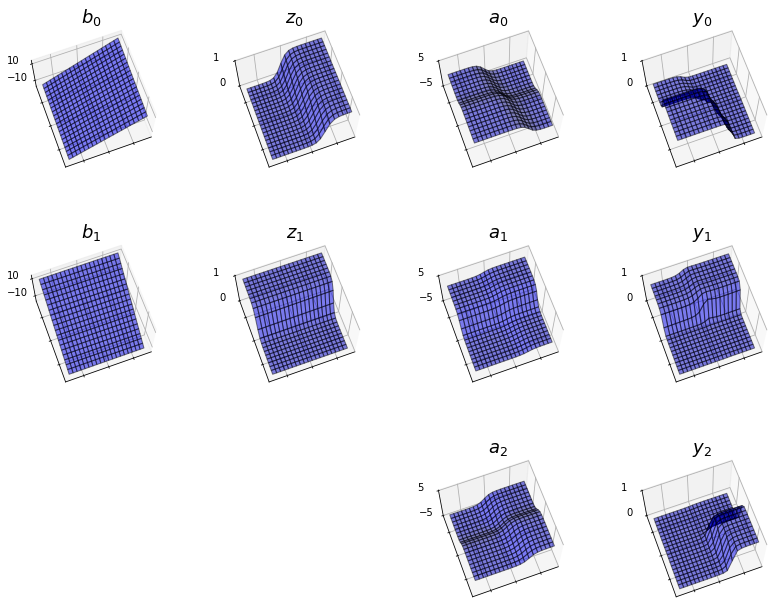

In [15]:
# リスト 7-1-(14)
# サーフェス表示関数 ----------
def show_activation3d(ax, xx0, xx1, f, f_ticks, title):
    x1_n, x0_n = xx0.shape
    f = f.reshape(x1_n, x0_n)
    ax.plot_surface(
        xx0, xx1, f,
        rstride=1, cstride=1, alpha=0.5, color="blue", edgecolor="black",
    )
    ax.view_init(70, -110)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticks(f_ticks)
    ax.set_title(title, fontsize=18)

# メイン ----------
M, K = 2, 3
x0_n, x1_n = 20, 20  # 等高線表示の解像度
# 表示データの計算
x0 = np.linspace(X0_min, X0_max, x0_n)
x1 = np.linspace(X1_min, X1_max, x1_n)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[xx0.reshape(-1), xx1.reshape(-1)]
y, a, z, b = FNN(wv, M, K, x)
# グラフ描画
fig = plt.figure(figsize=(12, 9))
plt.subplots_adjust(
    left=0.075, bottom=0.05, right=0.95, top=0.95,
    wspace=0.4, hspace=0.4,
)
# b,zの表示
for m in range(M):
    ax = fig.add_subplot(3, 4, 1 + m * 4, projection="3d")
    show_activation3d(ax, xx0, xx1, b[:, m], [-10, 10], f"$b_{m:d}$")
    ax = fig.add_subplot(3, 4, 2 + m * 4, projection="3d")
    show_activation3d(ax, xx0, xx1, z[:, m], [0, 1], f"$z_{m:d}$")
# a,yの表示
for k in range(K):
    ax = fig.add_subplot(3, 4, 3 + k * 4, projection="3d")
    show_activation3d(ax, xx0, xx1, a[:, k], [-5, 5], f"$a_{k:d}$")
    ax = fig.add_subplot(3, 4, 4 + k * 4, projection="3d")
    show_activation3d(ax, xx0, xx1, y[:, k], [0, 1], f"$y_{k:d}$")
        
plt.show()

## 7.3 Keras でニューラルネットワークモデル

### 7.3.1 2層フィードフォワードニューラルネット

In [8]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [9]:
# リスト 7-2-(1)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

# データの load ----------
data = np.load("ch7_data.npz")
X_train = data["X_train"]
T_train = data["T_train"]
X_test = data["X_test"]
T_test = data["T_test"]
X0_min = data["X0_min"]
X0_max = data["X0_max"]
X1_min = data["X1_min"]
X1_max = data["X1_max"]

In [10]:
# リスト 7-2-(2) 
# データの図示 ----------
def show_data(x, t):
    K = t.shape[1]  # tの列数からクラス数を取得
    col = ["gray", "white", "black"]
    for k in range(K):
        plt.plot(
            x[t[:, k] == 1, 0], x[t[:, k] == 1, 1], col[k],
            marker="o", linestyle="None",
            markeredgecolor="black", alpha=0.8,
        )
    plt.xlim(X0_min, X0_max)
    plt.ylim(X1_min, X1_max)

In [11]:
# リスト 7-2-(3)
import tensorflow
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

tensorflow.random.set_seed(seed=0)  # 乱数の固定

# Sequentialモデルの作成 ----------
model = Sequential()  # (A)
model.add(Dense(units=2, input_dim=2, activation="sigmoid"))  # (B)
model.add(Dense(units=3, activation="softmax"))  # (C)

# 学習方法の設定 ----------
sgd = SGD(learning_rate=0.5)  # (D) 
model.compile(  # (E)
    optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])
    
# 学習 ----------
start_time = time.time()
history = model.fit(  # (F)
    X_train, T_train,
    epochs=1000, batch_size=100, verbose=0,
    validation_data=(X_test, T_test),
)

# モデル評価 ----------
score = model.evaluate(X_test, T_test, verbose=0)  # (G)
calculation_time = time.time() - start_time

# 結果表示 ----------
print(f"cross entropy {score[0]:.2f}, accuracy {score[1]:.2f}")
print(f"Calculation time:{calculation_time:.2f} sec")

cross entropy 0.28, accuracy 0.89
Calculation time:14.76 sec


ここで Import Errorが発生する人が大半だと思います。
コードの2－5行目はpythonのモジュールのインポートがされてますが、あらかじめtensorflowのインストールを済ませてないと実行することができません。

大学のPCで課題をしているとこのtensorflowをインストールする権限がないため、自分の環境(自身の持っているパソコン)で課題をすることをお勧めします。(tensorflowのソースを引っ張ってきて実行することは可能ですが、ファイルが大きい(数百MB)ので大学の個人用ストレージをかなり食われます)

windowsでのインストール↓

windowsの環境でやっている人は、Anaconda Promptを管理者として実行しましょう。(tensorflowのインストールに管理者権限が必要なため)

スタートメニューから、Anaconda Promptを右クリック、その他の管理者として実行を選びます。

すると、プロンプトが立ち上がるのでその画面で、

pip install tensorflow==2.7.0

と入力し、エンターを押してください。

すると Successfully Install とかでてきます。これでインストールが完了です。

linuxとかmacだとターミナルで

sudo pip3 install tensorflow==2.7.0

でsudoのパスワードを入力したらできると思います。


### 7.3.2 Keras の使い方の流れ

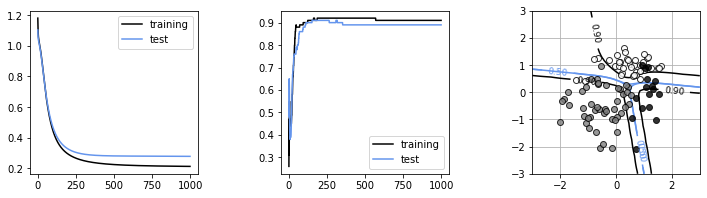

In [12]:
# リスト 7-2-(4)
plt.figure(figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)

# 学習曲線表示 ----------
plt.subplot(1, 3, 1)
# (A) 訓練データの誤差の表示
plt.plot(history.history["loss"], "black", label="training")
# (B) # テストデータの誤差の表示
plt.plot(history.history["val_loss"], "cornflowerblue", label="test")
plt.legend()

# 精度表示 ----------
plt.subplot(1, 3, 2)
# (C) 訓練データの正答率の表示
plt.plot(history.history["accuracy"], "black", label="training")
# (D) テストデータの正答率の表示
plt.plot(history.history["val_accuracy"], "cornflowerblue", label="test")
plt.legend()

# 境界線表示 ----------
plt.subplot(1, 3, 3)
show_data(X_test, T_test)
x0_n, x1_n = 60, 60  # 等高線表示の解像度
# 表示データの計算
x0 = np.linspace(X0_min, X0_max, x0_n)
x1 = np.linspace(X1_min, X1_max, x1_n)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[xx0.reshape(-1), xx1.reshape(-1)]
y = model.predict(x)  # (E) xに対するモデルの予測yを得る
# 等高線表示
K = 3
for ic in range(K):
    f = y[:, ic]
    f = f.reshape(x1_n, x0_n)
    cont = plt.contour(
        xx0, xx1, f,
        levels=[0.5, 0.9], colors=["cornflowerblue", "black"],
    )
    cont.clabel(fmt="%.2f", fontsize=9)
    plt.xlim(X0_min, X0_max)
    plt.ylim(X1_min, X1_max)
plt.grid()
plt.show()